In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

/usr/local/lib/python3.5/dist-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Download & Load MNIST Data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
def fully_connected_layer(x, output_size, initializer=tf.random_uniform_initializer(), activation=tf.nn.relu, count=0):
    w = tf.get_variable('w' + str(count), [x.get_shape()[1], output_size], initializer=initializer)
    b = tf.get_variable('b' + str(count), [output_size], initializer=initializer, dtype=tf.float32, trainable=True)
    
    print(w.name, b.name)
    
    l = tf.nn.bias_add(tf.matmul(x, w), b)
    
    return activation(l) if activation!=None else l, l, w, b

In [5]:
class ModelMaker(object):
    def __init__(self, layer_sizes):
        # Fully Connected Layers
        self.fcl_sizes = layer_sizes

        
    def create_layers(self, x, initializer=tf.truncated_normal_initializer, initializer_params={'dtype': tf.float32, 'stddev': 1e-1},\
                      name='noname', reuse=False):
        if not reuse:
            self.parameters = []

        last_layer = x
        last_size = int(np.prod(last_layer.get_shape()[1:]))

        with tf.variable_scope(name, reuse=reuse) as scope:
            # Generate Dense Layer
            for layer_count, ((layer_size, param_dict), dropout_use, constant_dropout, dropout_rate) in enumerate(self.fcl_sizes):
                last_layer, l, w, b = fully_connected_layer(x=last_layer, output_size=layer_size, \
                                                            initializer=initializer(**initializer_params), count=layer_count, **param_dict)
                
                if not reuse:
                    self.parameters = self.parameters + [w, b]

                if dropout_use:
                    if constant_dropout:
                        last_layer = tf.nn.dropout(last_layer, dropout_rate)
                    else:
                        last_layer = tf.nn.dropout(last_layer, self.dropout_rates[dropout_rate])

                        
                setattr(self, 'dense_%d_%s' % (layer_count+1, name), last_layer)

        self.last_layer = last_layer

In [6]:
# Reference : https://github.com/GunhoChoi/LSGAN_TF/blob/master/LSGAN/LSGAN_TF.ipynb
def LeakyReLU(x, leak=0.2, name='LeakyReLU'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [7]:
from PIL import Image
def ArrayToImage(arr):
    
    size = np.sqrt(arr.shape[0]).astype(int)
    arr = arr.reshape(size, size)
    
    img = Image.fromarray(np.uint8(arr))
    return img

from IPython import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import time

def DisplayHorizontal(images, header=None, width="100%", figsize=(20, 20), fontsize=20, depth=1):
    num_images = len(images)
    
    fig = plt.figure(figsize=figsize)
    for i in range(num_images):
        image = images[i]
        
        fig.add_subplot(depth, num_images/depth, i+1)
        plt.axis('off')
        if header != None:
            plt.title(header[i], fontsize=fontsize)
        plt.imshow(image, cmap='Greys_r', interpolation='nearest')

In [8]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
lb = LabelBinarizer()
lb.fit(range(10))

# Implement Option

In [10]:
z_var_dim = 100
z_category = 10
z_weight = 2

z_size = z_var_dim + z_category + z_weight

img_size = 784

generator_layer_shape = (
    ((128, {}), False, None, None),
    ((256, {}), False, None, None),
    ((img_size, {'activation': tf.nn.tanh}), False, None, None),
)

discriminator_layer_shape = (
    ((256, {'activation': LeakyReLU}), False, None, None),
    ((128, {'activation': LeakyReLU}), False, None, None),
)

# Train option

In [11]:
epoch_size = 100
batch_size = 512
d_train_epoch = 4
g_train_epoch = 1

# Implement variable & model

In [12]:
with tf.device('/gpu:0'):            
    G = ModelMaker(generator_layer_shape)
    D = ModelMaker(discriminator_layer_shape)
        
    Z_Var = tf.placeholder(tf.float32, [None, z_var_dim])
    Z_Category = tf.placeholder(tf.float32, [None, z_category])
    Z_Weight = tf.placeholder(tf.float32, [None, z_weight])
    
    Z = tf.concat([Z_Var, Z_Category, Z_Weight], 1)
    #Z = tf.concat([Z_Var, Z_Category], 1)

    G.create_layers(Z, name='Generator')
    X_Fake = G.last_layer
    X_Real = tf.placeholder(tf.float32, [None, img_size])
    Y = tf.placeholder(tf.float32, shape=[None, z_category])
    
    # Fake Data
    D.create_layers(X_Fake, name='Discriminator')
    FC_Fake = D.last_layer
    with tf.variable_scope('Discriminator'):
        Y_Fake, Y_Fake_Logits = fully_connected_layer(FC_Fake, 1, activation=tf.nn.sigmoid, count='output')[:2]
        Y_Fake_Category = fully_connected_layer(FC_Fake, z_category, activation=LeakyReLU, count='category')[0]
        Y_Fake_Weight = fully_connected_layer(FC_Fake, z_weight, activation=tf.nn.tanh, count='weight')[0]
        
    # Real Data
    D.create_layers(X_Real, name='Discriminator', reuse=True)
    FC_Real = D.last_layer    
    with tf.variable_scope('Discriminator', reuse=True):
        Y_Real, Y_Real_Logits = fully_connected_layer(FC_Real, 1, activation=tf.nn.sigmoid, count='output')[:2]
        Y_Real_Category = fully_connected_layer(FC_Real, z_category, activation=LeakyReLU, count='category')[0]
        Y_Real_Weight = fully_connected_layer(FC_Real, z_weight, activation=tf.nn.tanh, count='weight')[0]
    
    Optimizer_D = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=5e-1)
    Optimizer_G = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=5e-1)
    
    Loss_D = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Y_Real_Logits, labels=tf.ones_like(Y_Real)) + \
                            tf.nn.sigmoid_cross_entropy_with_logits(logits=Y_Fake_Logits, labels=tf.zeros_like(Y_Fake)))
    Loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Y_Fake_Logits, labels=tf.ones_like(Y_Fake)))
    
    Loss_D_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=Y_Real_Category))
    Loss_G_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Z_Category, logits=Y_Fake_Category))
    
    Loss_G_Weight = tf.losses.mean_squared_error(Y_Fake_Weight, Z_Weight)
    
    Loss_D_Total = Loss_D + Loss_D_Category
    Loss_G_Total = Loss_G + Loss_G_Category + Loss_G_Weight
    
    Param_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
    Param_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
    
    Grad_D = Optimizer_D.compute_gradients(Loss_D_Total, Param_D)
    Grad_G = Optimizer_G.compute_gradients(Loss_G_Total, Param_G)
    
    Train_D = Optimizer_D.apply_gradients(Grad_D)
    Train_G = Optimizer_G.apply_gradients(Grad_G)

Generator/w0:0 Generator/b0:0
Generator/w1:0 Generator/b1:0
Generator/w2:0 Generator/b2:0
Discriminator/w0:0 Discriminator/b0:0
Discriminator/w1:0 Discriminator/b1:0
Discriminator/woutput:0 Discriminator/boutput:0
Discriminator/wcategory:0 Discriminator/bcategory:0
Discriminator/wweight:0 Discriminator/bweight:0
Discriminator/w0:0 Discriminator/b0:0
Discriminator/w1:0 Discriminator/b1:0
Discriminator/woutput:0 Discriminator/boutput:0
Discriminator/wcategory:0 Discriminator/bcategory:0
Discriminator/wweight:0 Discriminator/bweight:0


# Train & show Result

In [13]:
z_sample = np.random.normal(0, 1, size=(10, z_var_dim)).astype(np.float32)
z_label = lb.transform(range(10))
z_weight = np.random.random(size=[10, z_weight]) * 2 - 1

In [14]:
z_sample = np.concatenate([z_sample, z_label, z_weight], axis=1)

In [19]:
display_epoch = 10

In [20]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.1, allow_growth=True)))
tf.global_variables_initializer().run(session=sess)

Epoch : 0, loss_d & total : 0.5807 & 1.0745, loss_g & total : 8.9032 & 12.5133


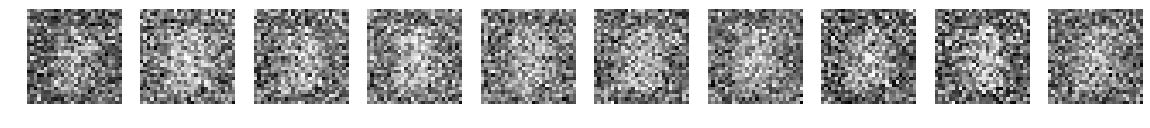

Epoch : 1, loss_d & total : 0.1564 & 0.3688, loss_g & total : 4.7995 & 8.1301
Epoch : 2, loss_d & total : 0.1767 & 0.3371, loss_g & total : 4.8151 & 8.0378
Epoch : 3, loss_d & total : 0.2180 & 0.3513, loss_g & total : 4.7151 & 7.5135
Epoch : 4, loss_d & total : 0.2332 & 0.3441, loss_g & total : 4.5363 & 6.1540
Epoch : 5, loss_d & total : 0.2624 & 0.3589, loss_g & total : 4.2562 & 5.4404
Epoch : 6, loss_d & total : 0.4550 & 0.5550, loss_g & total : 4.1630 & 5.2693
Epoch : 7, loss_d & total : 0.2924 & 0.3652, loss_g & total : 3.9137 & 5.0778
Epoch : 8, loss_d & total : 0.5312 & 0.6124, loss_g & total : 3.6918 & 4.8350
Epoch : 9, loss_d & total : 0.2931 & 0.3490, loss_g & total : 3.8142 & 4.9922
Epoch : 10, loss_d & total : 0.3073 & 0.3543, loss_g & total : 3.9460 & 5.1421


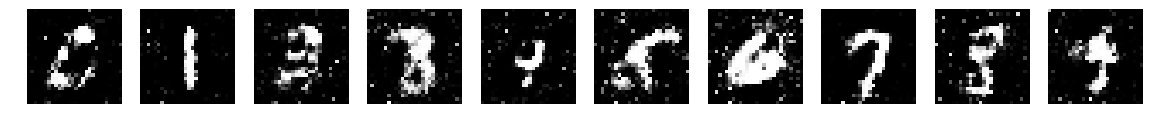

Epoch : 11, loss_d & total : 0.9524 & 1.0719, loss_g & total : 3.3586 & 4.5470
Epoch : 12, loss_d & total : 0.3270 & 0.3745, loss_g & total : 3.5474 & 4.6083
Epoch : 13, loss_d & total : 0.3173 & 0.3531, loss_g & total : 3.7506 & 4.8498
Epoch : 14, loss_d & total : 0.3314 & 0.3643, loss_g & total : 3.7757 & 4.8728
Epoch : 15, loss_d & total : 0.3657 & 0.3961, loss_g & total : 3.6724 & 4.7707
Epoch : 16, loss_d & total : 0.3873 & 0.4191, loss_g & total : 3.6261 & 4.7375
Epoch : 17, loss_d & total : 0.3830 & 0.4079, loss_g & total : 3.6517 & 4.7540
Epoch : 18, loss_d & total : 1.2897 & 1.4394, loss_g & total : 3.9969 & 5.1256
Epoch : 19, loss_d & total : 0.4397 & 0.4761, loss_g & total : 2.9876 & 3.9415
Epoch : 20, loss_d & total : 0.4058 & 0.4288, loss_g & total : 3.2497 & 4.2343


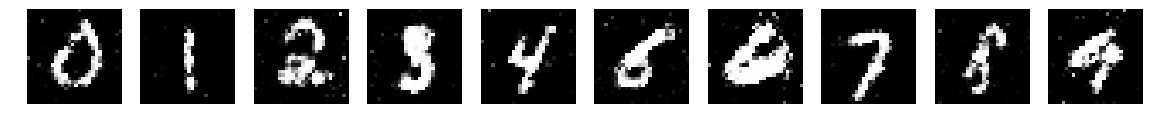

Epoch : 21, loss_d & total : 0.4338 & 0.4540, loss_g & total : 3.2373 & 4.2459
Epoch : 22, loss_d & total : 0.4553 & 0.4742, loss_g & total : 3.1473 & 4.1619
Epoch : 23, loss_d & total : 0.4731 & 0.4916, loss_g & total : 3.0904 & 4.0978
Epoch : 24, loss_d & total : 0.5050 & 0.5231, loss_g & total : 3.0402 & 4.0409
Epoch : 25, loss_d & total : 0.5136 & 0.5313, loss_g & total : 3.0310 & 4.0520
Epoch : 26, loss_d & total : 0.5360 & 0.5538, loss_g & total : 2.9116 & 3.9249
Epoch : 27, loss_d & total : 0.5294 & 0.5466, loss_g & total : 2.8954 & 3.9164
Epoch : 28, loss_d & total : 1.0262 & 1.1360, loss_g & total : 2.7597 & 3.8191
Epoch : 29, loss_d & total : 0.5131 & 0.5317, loss_g & total : 2.8054 & 3.7934
Epoch : 30, loss_d & total : 0.5436 & 0.5581, loss_g & total : 2.7588 & 3.7706


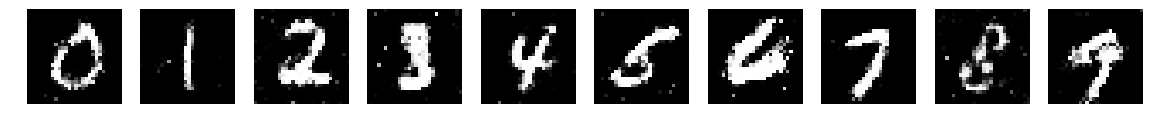

Epoch : 31, loss_d & total : 0.5655 & 0.5790, loss_g & total : 2.6890 & 3.6931
Epoch : 32, loss_d & total : 0.5817 & 0.5962, loss_g & total : 2.7378 & 3.7263
Epoch : 33, loss_d & total : 0.5763 & 0.5900, loss_g & total : 2.6496 & 3.6591
Epoch : 34, loss_d & total : 0.5882 & 0.6007, loss_g & total : 2.6837 & 3.6680
Epoch : 35, loss_d & total : 0.6082 & 0.6225, loss_g & total : 2.6379 & 3.6242
Epoch : 36, loss_d & total : 0.6088 & 0.6219, loss_g & total : 2.6799 & 3.6659
Epoch : 37, loss_d & total : 0.6190 & 0.6306, loss_g & total : 2.6505 & 3.6465
Epoch : 38, loss_d & total : 0.6181 & 0.6311, loss_g & total : 2.5787 & 3.5394
Epoch : 39, loss_d & total : 0.6293 & 0.6415, loss_g & total : 2.6445 & 3.6211
Epoch : 40, loss_d & total : 0.6325 & 0.6437, loss_g & total : 2.5221 & 3.4886


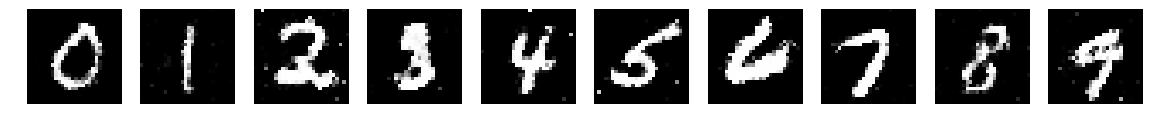

Epoch : 41, loss_d & total : 0.6267 & 0.6381, loss_g & total : 2.5637 & 3.5377
Epoch : 42, loss_d & total : 0.6365 & 0.6474, loss_g & total : 2.5315 & 3.4858
Epoch : 43, loss_d & total : 0.6370 & 0.6476, loss_g & total : 2.4982 & 3.4609
Epoch : 44, loss_d & total : 0.6388 & 0.6495, loss_g & total : 2.5882 & 3.5427
Epoch : 45, loss_d & total : 0.6506 & 0.6612, loss_g & total : 2.5264 & 3.4604
Epoch : 46, loss_d & total : 0.6473 & 0.6577, loss_g & total : 2.5347 & 3.4862
Epoch : 47, loss_d & total : 0.6508 & 0.6611, loss_g & total : 2.4196 & 3.3584
Epoch : 48, loss_d & total : 0.6650 & 0.6758, loss_g & total : 2.4971 & 3.4315
Epoch : 49, loss_d & total : 0.6551 & 0.6654, loss_g & total : 2.4925 & 3.4233
Epoch : 50, loss_d & total : 0.6538 & 0.6638, loss_g & total : 2.5193 & 3.4575


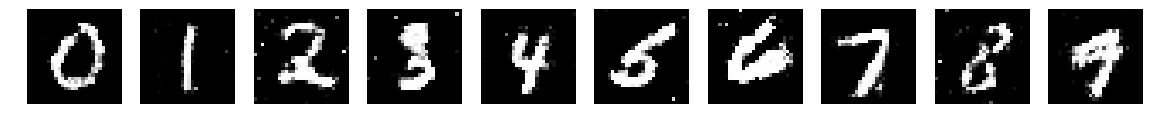

Epoch : 51, loss_d & total : 0.6697 & 0.6788, loss_g & total : 2.4075 & 3.3377
Epoch : 52, loss_d & total : 0.6660 & 0.6763, loss_g & total : 2.3806 & 3.3159
Epoch : 53, loss_d & total : 0.6690 & 0.6791, loss_g & total : 2.4307 & 3.3666
Epoch : 54, loss_d & total : 0.6753 & 0.6847, loss_g & total : 2.4271 & 3.3639
Epoch : 55, loss_d & total : 0.6757 & 0.6850, loss_g & total : 2.4143 & 3.3455
Epoch : 56, loss_d & total : 0.6901 & 0.6998, loss_g & total : 2.4394 & 3.3741
Epoch : 57, loss_d & total : 0.6762 & 0.6854, loss_g & total : 2.3762 & 3.2998
Epoch : 58, loss_d & total : 0.6877 & 0.6973, loss_g & total : 2.3653 & 3.2817
Epoch : 59, loss_d & total : 0.6939 & 0.7028, loss_g & total : 2.3016 & 3.2094
Epoch : 60, loss_d & total : 0.6901 & 0.6998, loss_g & total : 2.3196 & 3.2364


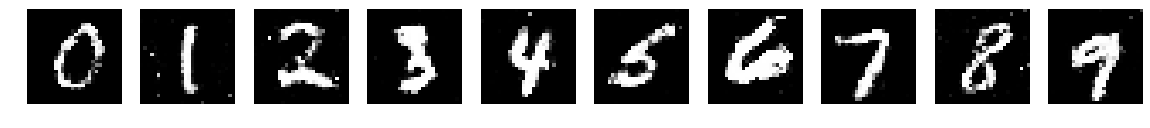

Epoch : 61, loss_d & total : 0.6860 & 0.6951, loss_g & total : 2.3619 & 3.2627
Epoch : 62, loss_d & total : 0.6918 & 0.7013, loss_g & total : 2.3631 & 3.2896
Epoch : 63, loss_d & total : 0.6877 & 0.6970, loss_g & total : 2.3603 & 3.2874
Epoch : 64, loss_d & total : 0.6937 & 0.7030, loss_g & total : 2.2983 & 3.2091
Epoch : 65, loss_d & total : 0.6965 & 0.7059, loss_g & total : 2.3514 & 3.2586
Epoch : 66, loss_d & total : 0.6912 & 0.7002, loss_g & total : 2.2715 & 3.1737
Epoch : 67, loss_d & total : 0.6957 & 0.7049, loss_g & total : 2.3370 & 3.2435
Epoch : 68, loss_d & total : 0.7008 & 0.7099, loss_g & total : 2.2872 & 3.2025
Epoch : 69, loss_d & total : 0.6913 & 0.7002, loss_g & total : 2.2911 & 3.1857
Epoch : 70, loss_d & total : 0.7077 & 0.7160, loss_g & total : 2.2753 & 3.1677


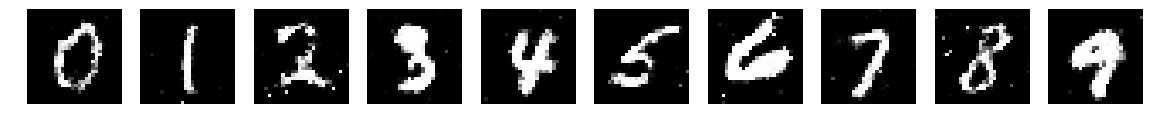

Epoch : 71, loss_d & total : 0.6941 & 0.7034, loss_g & total : 2.3550 & 3.2546
Epoch : 72, loss_d & total : 0.7060 & 0.7158, loss_g & total : 2.2743 & 3.1784
Epoch : 73, loss_d & total : 0.7018 & 0.7105, loss_g & total : 2.3001 & 3.2071
Epoch : 74, loss_d & total : 0.7026 & 0.7126, loss_g & total : 2.2856 & 3.1899
Epoch : 75, loss_d & total : 0.7051 & 0.7142, loss_g & total : 2.2966 & 3.1868
Epoch : 76, loss_d & total : 0.7007 & 0.7103, loss_g & total : 2.2952 & 3.1890
Epoch : 77, loss_d & total : 0.7070 & 0.7157, loss_g & total : 2.2558 & 3.1498
Epoch : 78, loss_d & total : 0.7093 & 0.7180, loss_g & total : 2.3497 & 3.2508
Epoch : 79, loss_d & total : 0.7065 & 0.7157, loss_g & total : 2.2705 & 3.1553
Epoch : 80, loss_d & total : 0.6993 & 0.7082, loss_g & total : 2.2663 & 3.1511


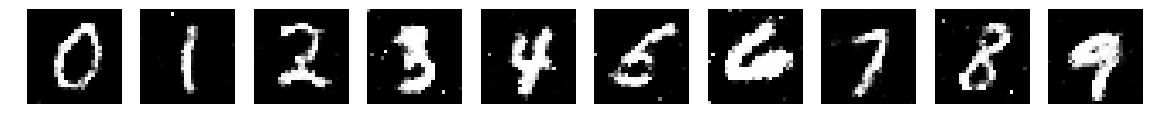

Epoch : 81, loss_d & total : 0.7060 & 0.7155, loss_g & total : 2.3410 & 3.2185
Epoch : 82, loss_d & total : 0.7047 & 0.7134, loss_g & total : 2.4026 & 3.2885
Epoch : 83, loss_d & total : 0.7005 & 0.7093, loss_g & total : 2.3358 & 3.2281
Epoch : 84, loss_d & total : 0.7173 & 0.7259, loss_g & total : 2.2500 & 3.1522
Epoch : 85, loss_d & total : 0.7022 & 0.7112, loss_g & total : 2.3646 & 3.2520
Epoch : 86, loss_d & total : 0.7040 & 0.7135, loss_g & total : 2.2579 & 3.1474
Epoch : 87, loss_d & total : 0.7128 & 0.7225, loss_g & total : 2.2920 & 3.1799
Epoch : 88, loss_d & total : 0.7151 & 0.7244, loss_g & total : 2.4007 & 3.2920
Epoch : 89, loss_d & total : 0.7064 & 0.7154, loss_g & total : 2.2781 & 3.1653
Epoch : 90, loss_d & total : 0.7075 & 0.7170, loss_g & total : 2.2826 & 3.1654


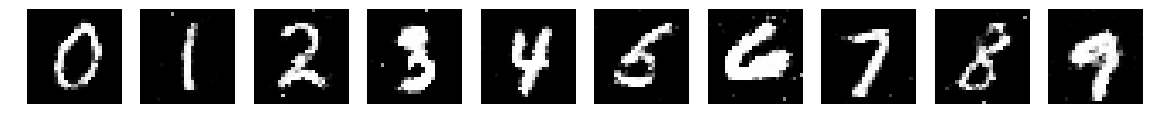

Epoch : 91, loss_d & total : 0.7099 & 0.7193, loss_g & total : 2.2462 & 3.1308
Epoch : 92, loss_d & total : 0.7148 & 0.7237, loss_g & total : 2.2761 & 3.1616
Epoch : 93, loss_d & total : 0.7025 & 0.7112, loss_g & total : 2.2442 & 3.1263
Epoch : 94, loss_d & total : 0.7058 & 0.7152, loss_g & total : 2.3228 & 3.2149
Epoch : 95, loss_d & total : 0.7138 & 0.7221, loss_g & total : 2.2834 & 3.1784
Epoch : 96, loss_d & total : 0.7074 & 0.7168, loss_g & total : 2.2949 & 3.1793
Epoch : 97, loss_d & total : 0.7034 & 0.7130, loss_g & total : 2.3726 & 3.2552
Epoch : 98, loss_d & total : 0.7054 & 0.7151, loss_g & total : 2.3219 & 3.2091
Epoch : 99, loss_d & total : 0.6946 & 0.7025, loss_g & total : 2.3232 & 3.1996


In [21]:
for i in range(epoch_size):
    ld = []
    ld_total = []
    lg = []
    lg_total = []
    
    count = int(mnist.train.num_examples / batch_size)
    for j in range(count):
        batch_train, batch_target = mnist.train.next_batch(batch_size)
        batch_train = batch_train.astype(np.float32) * 2 - 1
        
        batch_z = np.random.normal(0, 1, size=(batch_size, z_var_dim)).astype(np.float32)
        batch_z_category = lb.transform(np.random.randint(0, 10, size=batch_size))
        batch_z_weight = np.random.random(size=[batch_size, 2]) * 2 - 1
        
        # Discriminator Train
        for _ in range(d_train_epoch):
            _, loss_d, loss_d_total = sess.run([Train_D, Loss_D, Loss_D_Total], \
                                 feed_dict={X_Real: batch_train, Y: batch_target, \
                                            Z_Var: batch_z, Z_Category: batch_z_category, Z_Weight: batch_z_weight})
            ld += [loss_d]
            ld_total += [loss_d_total]

        # Generator Train
        for _ in range(g_train_epoch):
            _, loss_g, loss_g_total = sess.run([Train_G, Loss_G, Loss_G_Total], \
                                 feed_dict={Z_Var: batch_z, Z_Category: batch_z_category, Z_Weight: batch_z_weight})
            lg += [loss_g]
            lg_total += [loss_g_total]
            
    print('Epoch : %d, loss_d & total : %.4f & %.4f, loss_g & total : %.4f & %.4f' % \
          (i, np.mean(ld), np.mean(ld_total), np.mean(lg), np.mean(lg_total)))
    
    gen_mnist = sess.run(X_Fake, feed_dict={Z: z_sample})
    if i % display_epoch == 0:
        #display.clear_output(wait=True)
        DisplayHorizontal([ArrayToImage((x * 0.5 + 0.5) * 255) for x in gen_mnist])
        display.display(plt.gcf())
        plt.close()

# Test 

In [22]:
new_z_label = lb.transform([1] * 10)
#new_z_label = lb.transform(range(10))

In [23]:
new_z_weight = np.zeros([10, 2])
for i in range(10):
    new_z_weight[i][0] = np.linspace(-1, 1, 10)[i]
    new_z_weight[i][1] = np.linspace(-1, 1, 10)[i]

In [24]:
new_z_var = np.random.normal(0, 1, size=(10, z_var_dim)).astype(np.float32)

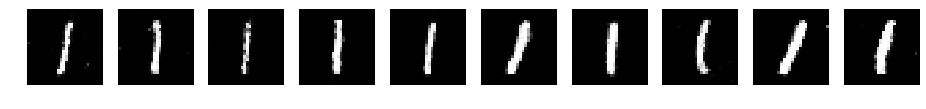

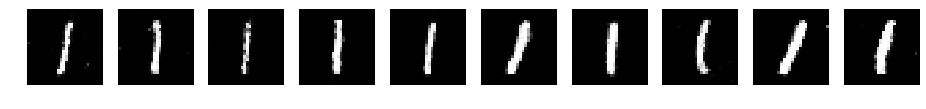

In [30]:
new_z_sample = np.concatenate([new_z_var, new_z_label, new_z_weight], axis=1)

gen_mnist = sess.run(X_Fake, feed_dict={Z: new_z_sample})
DisplayHorizontal([ArrayToImage((x * 0.5 + 0.5) * 255) for x in gen_mnist], depth=1, figsize=(16, 4*2))
display.display(plt.gcf())

In [ ]:
#Reference : https://github.com/Overseer66/Tensorflow-GAN/blob/master/Tensorflow%20Info%20GAN%20MNIST.ipynb